# $\textbf{Wind power forecasting}$
### $\textit{Kirill Zakharov}$
##### $\textit{@kirillzx}$
$2021$

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from itertools import product
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from fbprophet import Prophet

In [2]:
data = pd.read_csv('Turbine_Data.csv', parse_dates=True, index_col='Unnamed: 0')
data.index = pd.DatetimeIndex(data.index)
data = data.drop(['WTG', 'ControlBoxTemperature'], axis=1)
data = data.tz_localize(None)
names = data.columns

In [3]:
# data = data.resample('D').last()
data.head(3)

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
2017-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,94750.000000,93817.000000,62518.000000,41996.000000,41891.000000,41891.000000,62540.000000,62438.000000,62295.000000,62427.000000,62449.000000,62406.000000,62507.000000,72278.000000,94748.000000,62127.000000,6.290800e+04,72278.000000,94595.000000
mean,619.109805,28.774654,43.010189,9.749641,10.036535,10.036535,64.234170,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,196.290539,88.133966,9.907500,2.280429e+03,196.290539,5.878960
std,611.275373,4.369145,5.545312,20.644828,20.270465,20.270465,10.455556,6.323895,528.063946,22.627489,22.650255,5.178711,5.732783,88.296554,116.596725,4.718421,3.586034e+05,88.296554,2.619084
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,79.642258,25.627428,39.840247,-0.939849,-0.433264,-0.433264,57.872242,53.942181,1029.812177,55.492241,54.763998,33.943949,35.812500,145.000000,-0.432137,9.231091,2.000000e+00,145.000000,3.823330
50%,402.654893,28.340541,42.910877,0.394399,0.888977,0.888977,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,182.000000,35.883659,10.098702,2.000000e+00,182.000000,5.557765
75%,1074.591780,31.664772,47.007976,8.099302,8.480194,8.480194,71.079306,61.305312,1515.402005,85.867449,85.337740,40.008425,43.359375,271.000000,147.359075,13.600413,2.000000e+00,271.000000,7.506710
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


In [5]:
data.shape

(118224, 19)

In [6]:
data1 = data.dropna()
data1.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,32818.000000,3.281800e+04,32818.000000,32818.000000
mean,607.131170,28.381903,42.740275,10.567897,10.913872,10.913872,63.709906,56.982895,1078.730966,71.357338,70.709018,36.469768,39.543092,204.963269,118.168273,9.670314,4.231729e+03,204.963269,5.869203
std,599.599857,4.213329,4.918918,21.722311,21.498982,21.498982,9.894906,6.785388,533.799111,22.805603,22.813004,4.297798,4.972494,88.862388,121.728433,4.795469,4.964848e+05,88.862388,2.612695
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.962305
25%,79.662094,25.047413,39.665612,-0.947070,-0.441033,-0.441033,57.503406,53.223760,1029.752753,54.863560,54.120448,33.009880,35.746176,160.000000,14.701084,9.229526,2.000000e+00,160.000000,3.900237
50%,397.411226,27.915479,42.195745,0.274929,0.765667,0.765667,64.403095,56.767088,1105.432692,65.003930,64.213024,36.050614,39.164068,181.750000,78.449171,9.912869,2.000000e+00,181.750000,5.536355
75%,1043.984927,31.298447,46.286068,9.187188,9.571687,9.571687,69.502450,60.271263,1482.752844,83.260364,82.665896,39.352797,43.102944,270.982143,202.215458,13.298666,2.000000e+00,270.982143,7.430092
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,82.237932,70.764581,1793.657150,126.773031,126.043018,47.996185,54.230154,357.000000,363.354454,16.070668,6.574653e+07,357.000000,22.970893


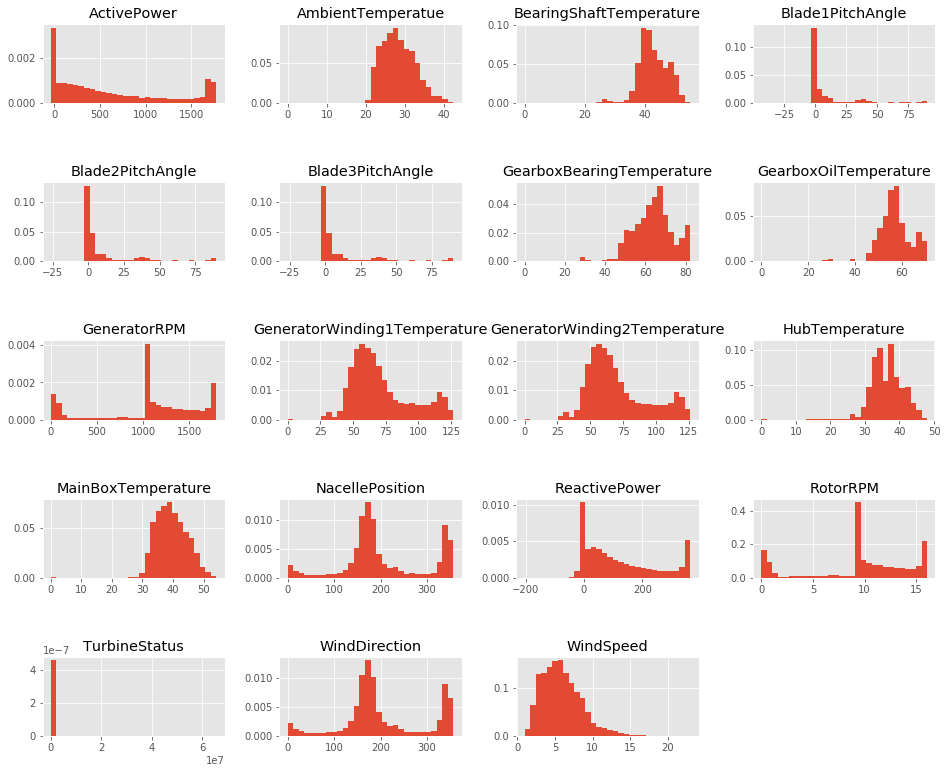

In [7]:
# histograms
data1.hist(figsize=(16,16), density=True, layout=(6,4), bins=30, sharex=False, sharey=False)
plt.subplots_adjust(hspace=1)
plt.show()

In [8]:
data2 = data.fillna(method='bfill')
data2.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,118224.000000,1.182240e+05,118224.000000,118224.000000
mean,618.270991,28.591784,43.647849,31.581330,30.499682,30.499682,67.476693,59.732698,1324.410764,85.591712,84.941125,37.346502,39.280551,199.753483,82.706411,11.873260,1.233005e+03,199.753483,5.886995
std,613.814274,4.770899,7.978345,22.078881,21.088869,21.088869,13.937473,5.894671,502.260424,25.226925,25.214096,7.470079,7.268660,92.961925,113.979858,4.504927,2.615880e+05,92.961925,2.697255
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,76.621418,25.527884,41.274587,1.685914,2.166650,2.166650,62.262288,56.139274,1046.127482,61.832495,61.042916,34.005226,37.924841,136.000000,-0.509435,9.379780,0.000000e+00,136.000000,3.840339
50%,398.731856,28.256318,45.182347,45.736893,43.699357,43.699357,72.779137,61.190019,1461.226517,88.846837,88.241977,38.013888,40.833333,186.250000,30.718335,13.075253,2.000000e+00,186.250000,5.566179
75%,1084.948613,31.639939,47.901936,45.736893,43.699357,43.699357,77.119133,64.204399,1751.715563,113.290871,112.592163,42.996094,41.898426,283.000000,132.817204,15.708135,2.000000e+00,283.000000,7.613288
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


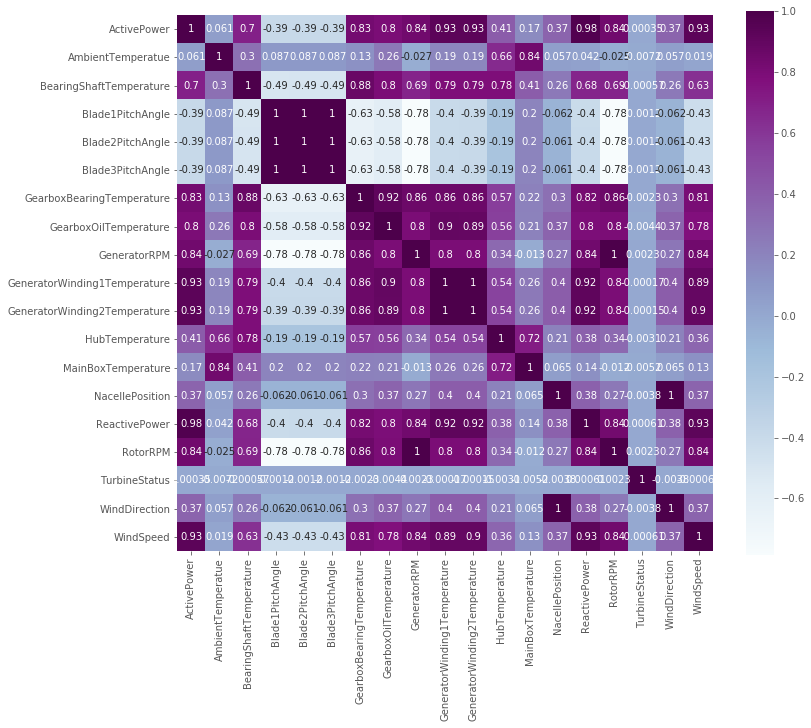

In [9]:
fig = plt.figure(figsize=(12,10))

sns.heatmap(data1.corr(), annot=True, cmap='BuPu', square=True, linewidth=0)
b1,t1=plt.ylim()
b1+=0.5
t1-=0.5
plt.ylim(b1, t1)
plt.show()

## Model with all features

### Linear Regression

In [10]:
X = data1.iloc[:,1:]
Y = data1.iloc[:, 0]
validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [11]:
model = LinearRegression()
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-112.26979712745683

In [12]:
model.fit(X_train, Y_train)
forecast = model.predict(X_test)

In [13]:
#r2
model.score(X_train, Y_train)

0.9749057934157515

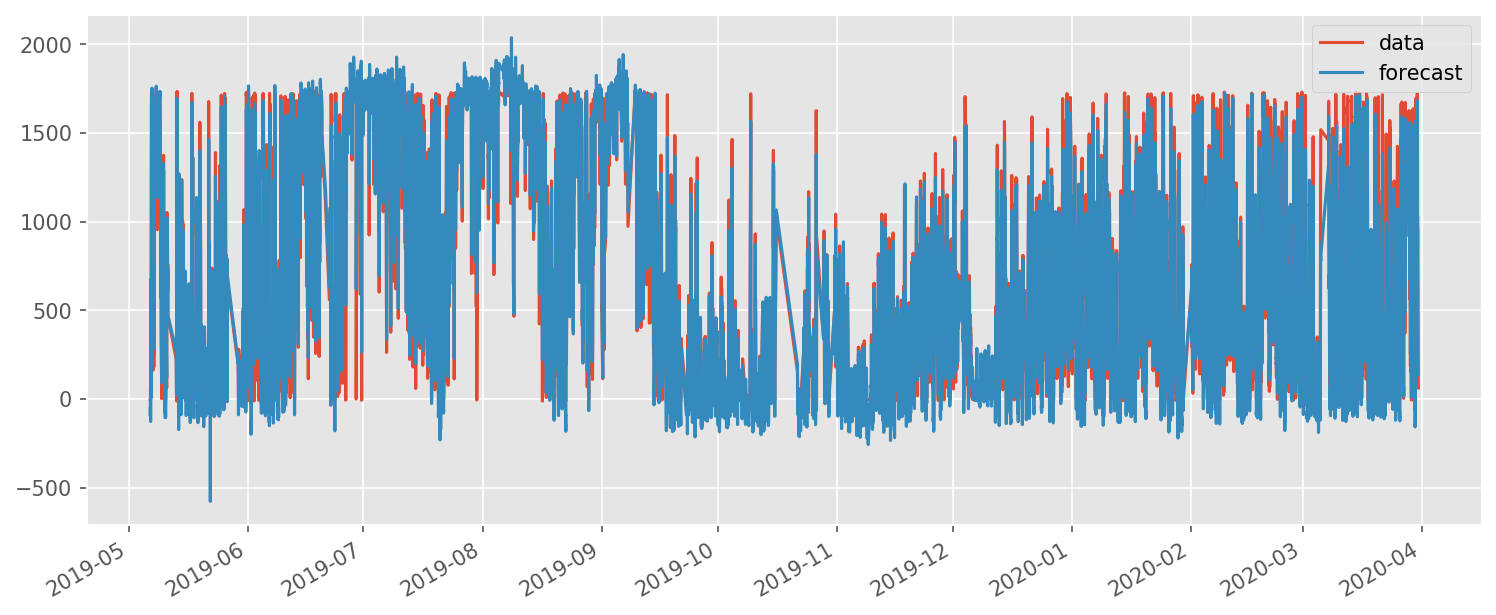

In [14]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
# plt.plot(data1.iloc[:, 0].values, label='data')
# plt.plot(model.predict(data1.iloc[:, 1:]), label='forecast')
df1 = pd.DataFrame(Y_test.values,\
                           index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)

plt.show()

## Model with selected features and droped NaN data

### Without resampling

In [15]:
names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed', 'Blade1PitchAngle']
X = data1[names_features]
Y = data1.iloc[:, 0]
X = X.copy()
Y = Y.copy()

validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [16]:
model = LinearRegression(normalize=True)
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-151.35699405929913

In [17]:
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

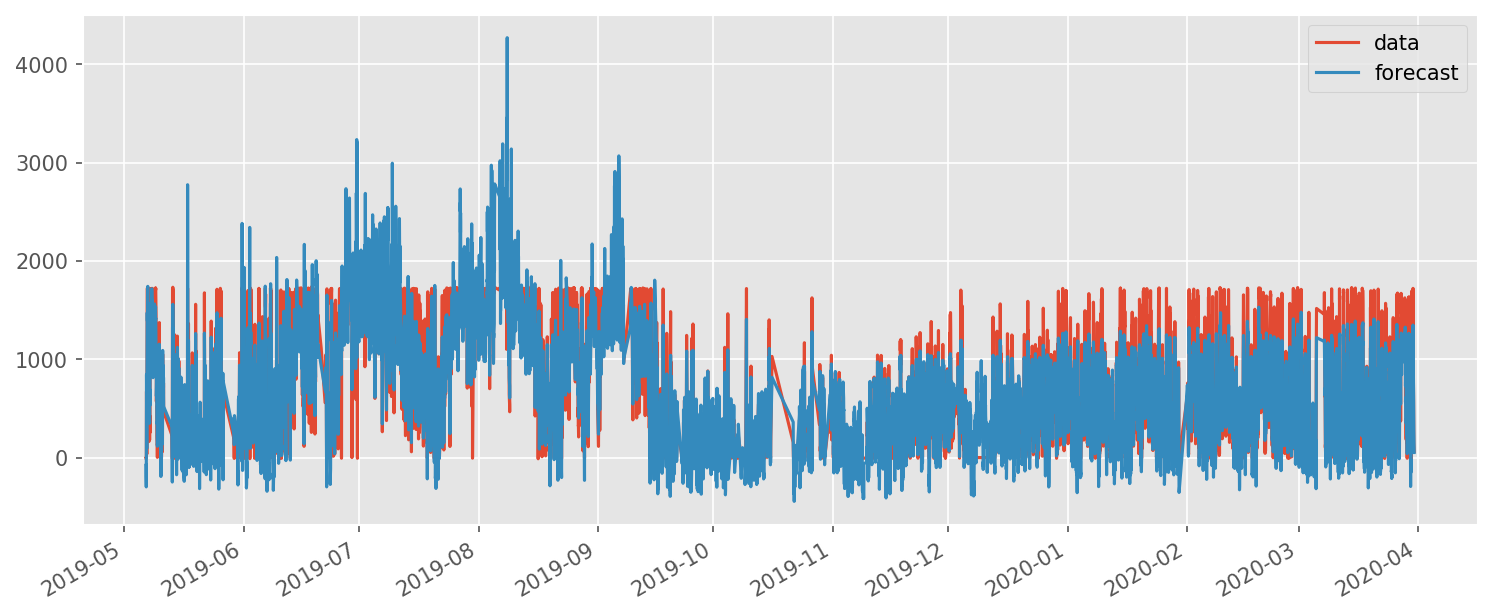

In [18]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
df1 = pd.DataFrame(Y_test.values,\
                           index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)
plt.legend()
plt.show()

### Transform to Normal distribution

In [63]:
names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed', 'Blade1PitchAngle']
X = data1[names_features]
Y = data1.iloc[:, 0]
X = X.copy()
Y = Y.copy()
X.loc[:, ['AmbientTemperatue', 'WindSpeed']] = np.log(X.loc[:, ['AmbientTemperatue', 'WindSpeed']]+200)

std_model = StandardScaler()
# std_model = Normalizer()
# X.loc[:, ['WindDirection']] = std_model.fit_transform(X.loc[:, ['WindDirection']].values.reshape(-1, 1))
# Y = pd.DataFrame(std_model.fit_transform(np.array(Y).reshape(-1, 1)), index=X.index, columns=['ActivePower'])

validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [64]:
model = LinearRegression(normalize=False)
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(cv.mean())
model.fit(X_train, Y_train)

-150.59892579035818


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

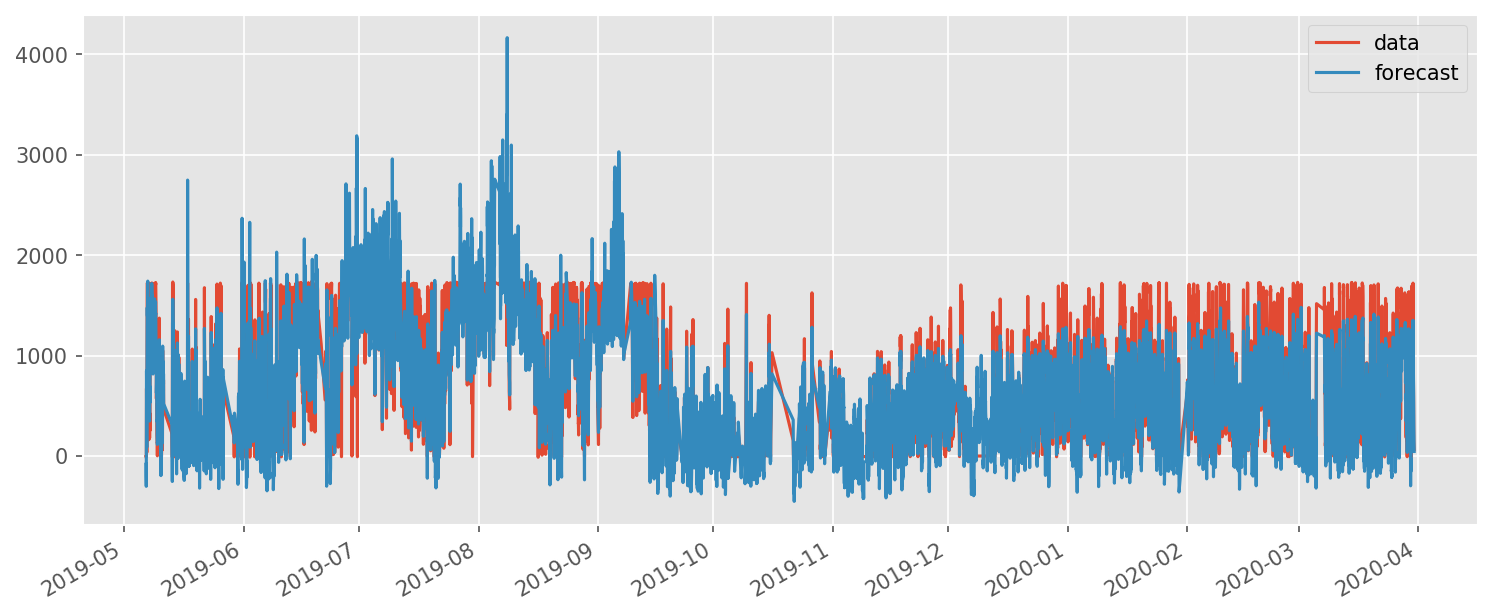

In [65]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
df1 = pd.DataFrame(Y_test.values,\
                           index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)
plt.legend()
plt.show()

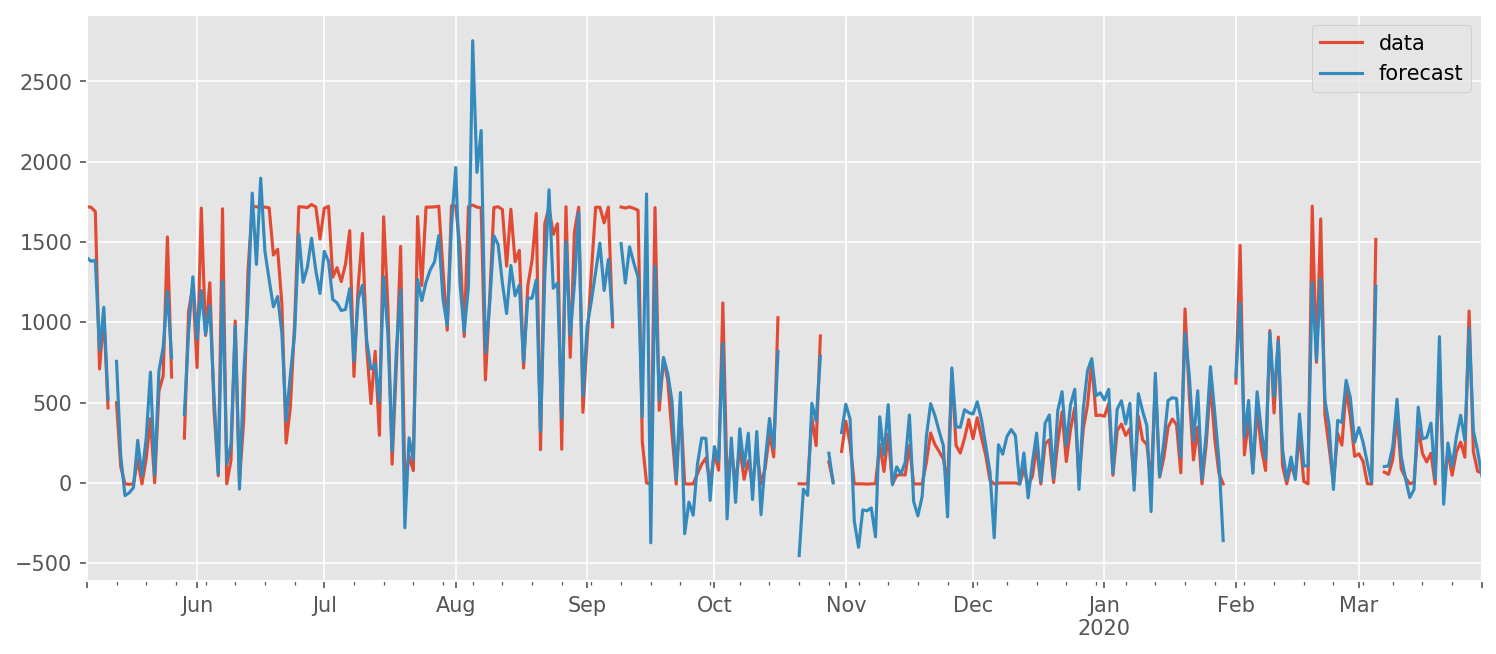

In [66]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1.resample('D').last().plot(ax=ax)
plt.legend()
plt.show()

### With resampling by days

In [24]:
names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed', 'Blade1PitchAngle']
data3 = data.resample('D').last().dropna()
X = data3[names_features]
Y = data3.iloc[:, 0]
X = X.copy()
# X.loc[:, ['AmbientTemperatue', 'WindSpeed']] = np.log(X.loc[:, ['AmbientTemperatue', 'WindSpeed']]+200)

validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [25]:
model = LinearRegression()
# model = Ridge()
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-130.84687048246786

In [28]:
model.fit(X_train, Y_train)
np.around(model.coef_)

array([ 21.,   0., 255.,   5.])

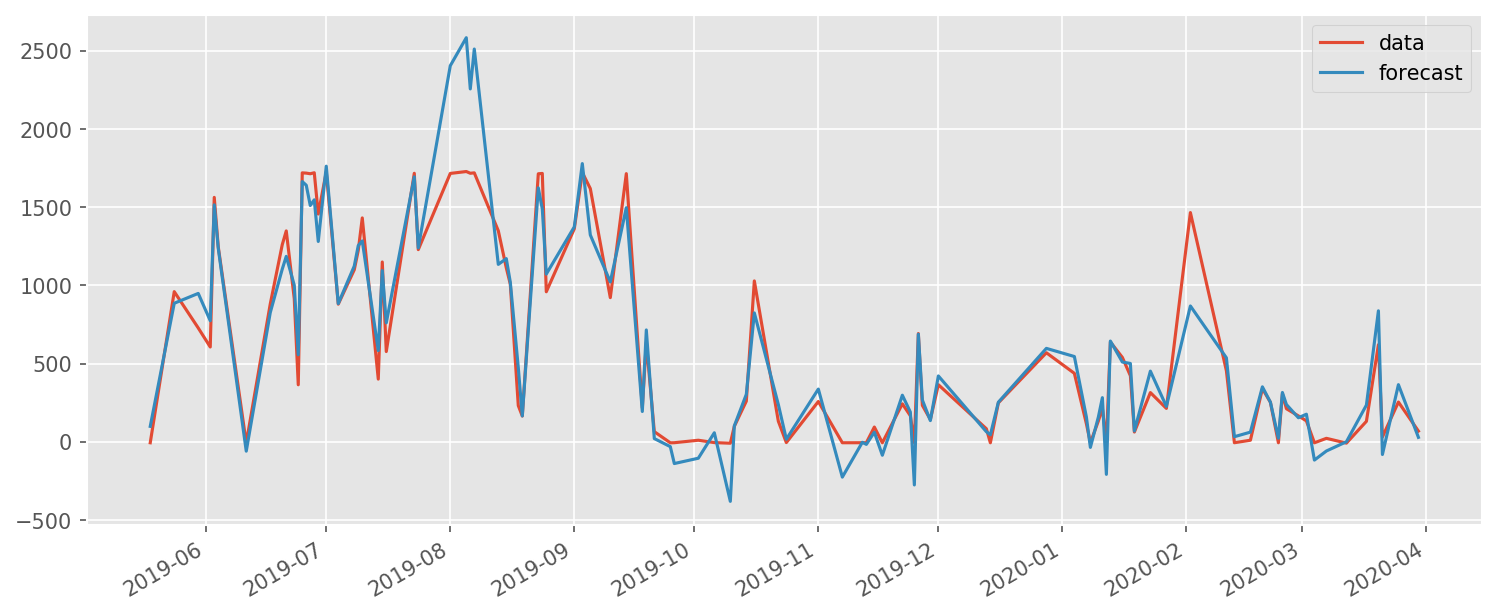

In [27]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
# plt.plot(data1.iloc[:, 0].values, label='data')
# plt.plot(Y_test.values, label='data')
# plt.plot(model.predict(X_test), label='forecast')
df1 = pd.DataFrame(Y_test.values,\
                           index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)
plt.legend()
plt.show()

### Only prophet

In [14]:
data_prophet = data1[['ActivePower']]
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']
    
model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
model.fit(data_prophet)
    
future = model.make_future_dataframe(periods=14, freq='D')
forecast = model.predict(future)

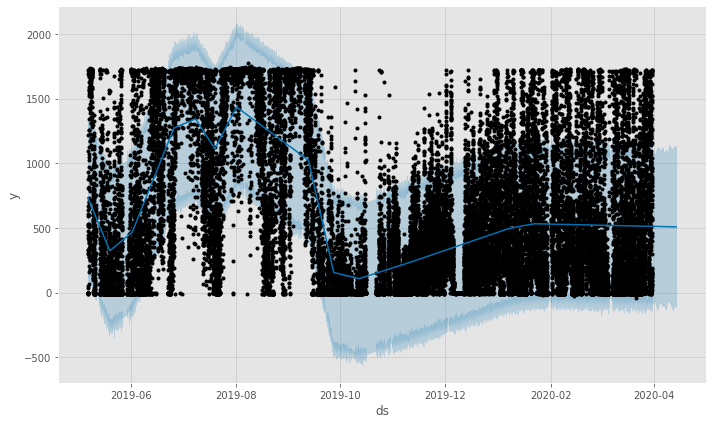

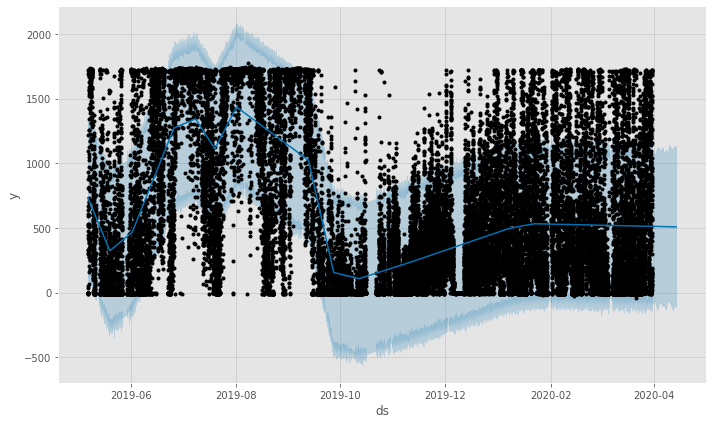

In [15]:
model.plot(forecast)

## Model with selected features and filled data 

In [68]:
names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed', 'Blade1PitchAngle']
X = data2[names_features]
Y = data2.iloc[:, 0]
X = X.copy()
X.loc[:, ['AmbientTemperatue', 'WindSpeed']] = np.log(X.loc[:, ['AmbientTemperatue', 'WindSpeed']]+200)
validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

model = LinearRegression(normalize=True)

# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-165.40158649490675

In [69]:
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

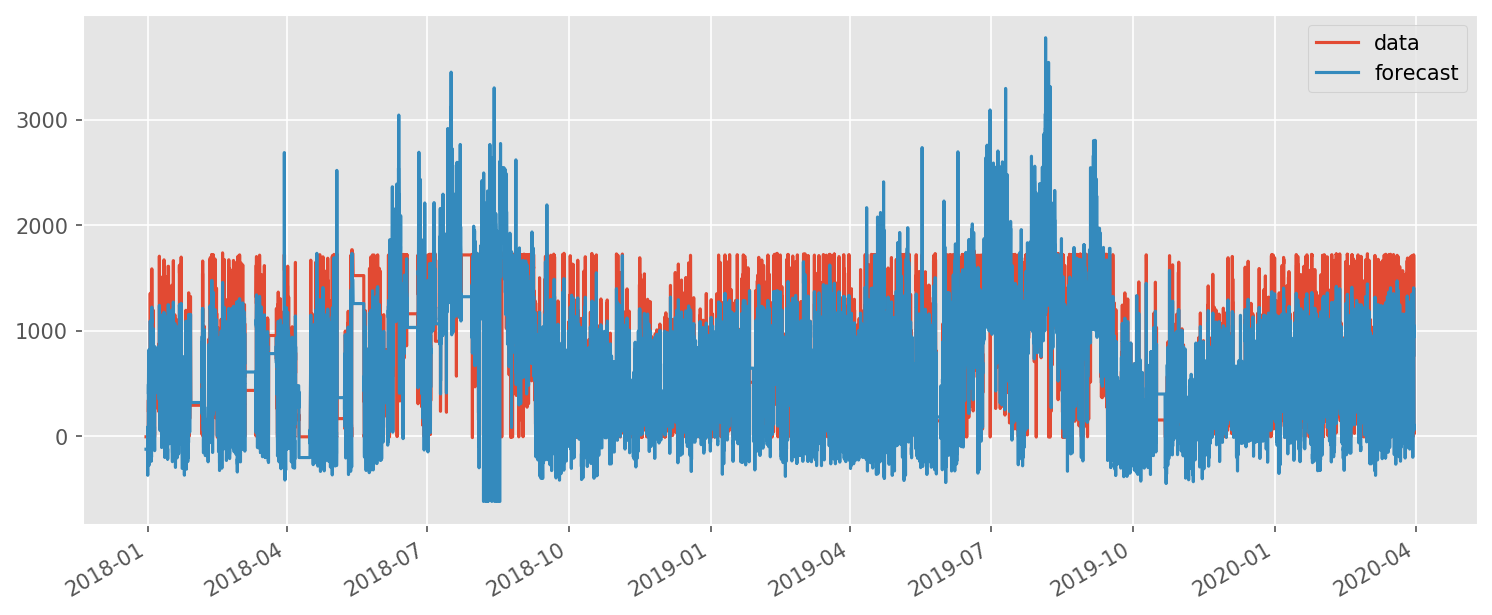

In [70]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1 = pd.DataFrame(Y_test.values, index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)

plt.show()

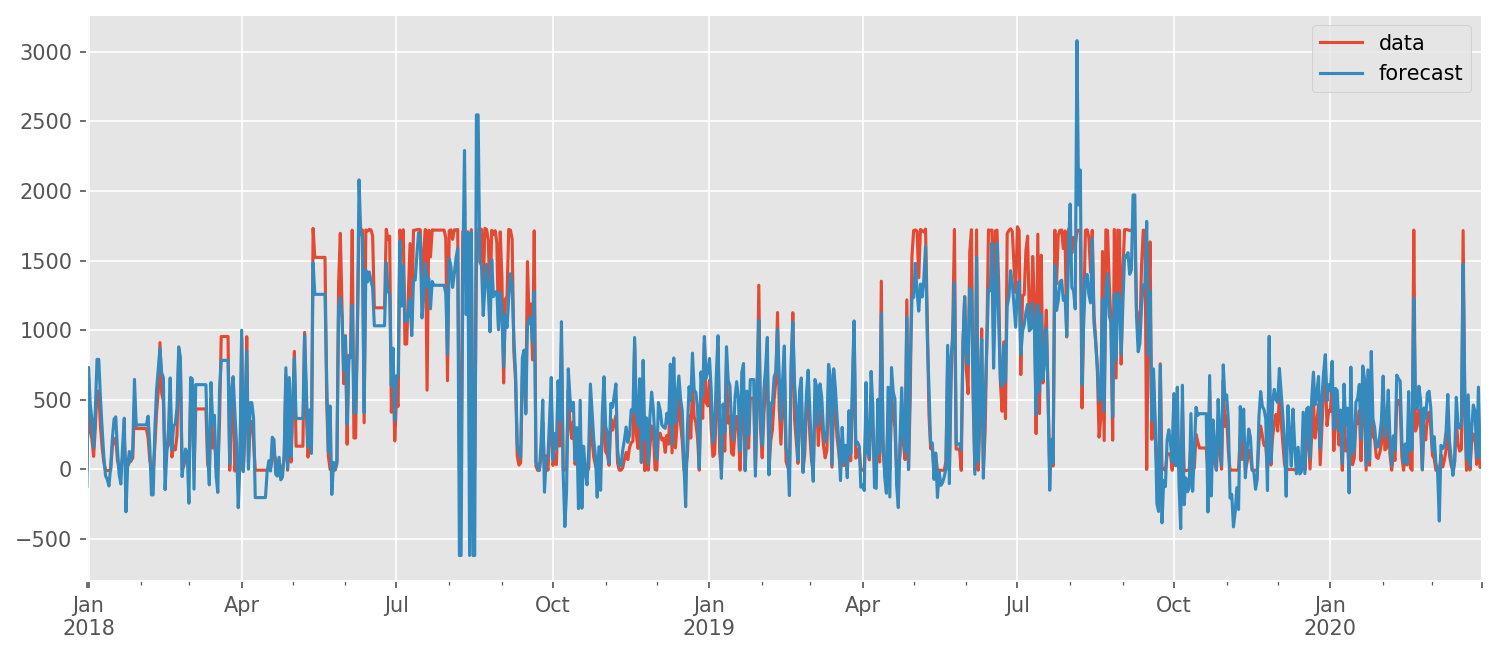

In [71]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1.resample('D').last().plot(ax=ax)
plt.legend()
plt.show()

### Model for blade's angle

In [81]:
# names_features = ['WindDirection', 'WindSpeed']
names_features_b = ['WindSpeed']
X = data1[names_features_b]
Y = data1[['Blade1PitchAngle']]
X = X.copy()
X.loc[:, ['WindSpeed']] = np.log(X.loc[:, ['WindSpeed']]+1)
validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [82]:
blade_model = LinearRegression(normalize=False)
# model = Ridge()
# scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(blade_model, X_train, Y_train, cv=kfold, scoring=scoring)
cv.mean()

-13.222804205763882

In [83]:
blade_model.fit(X_train, Y_train)
blade_model.coef_

array([[-32.45494445]])

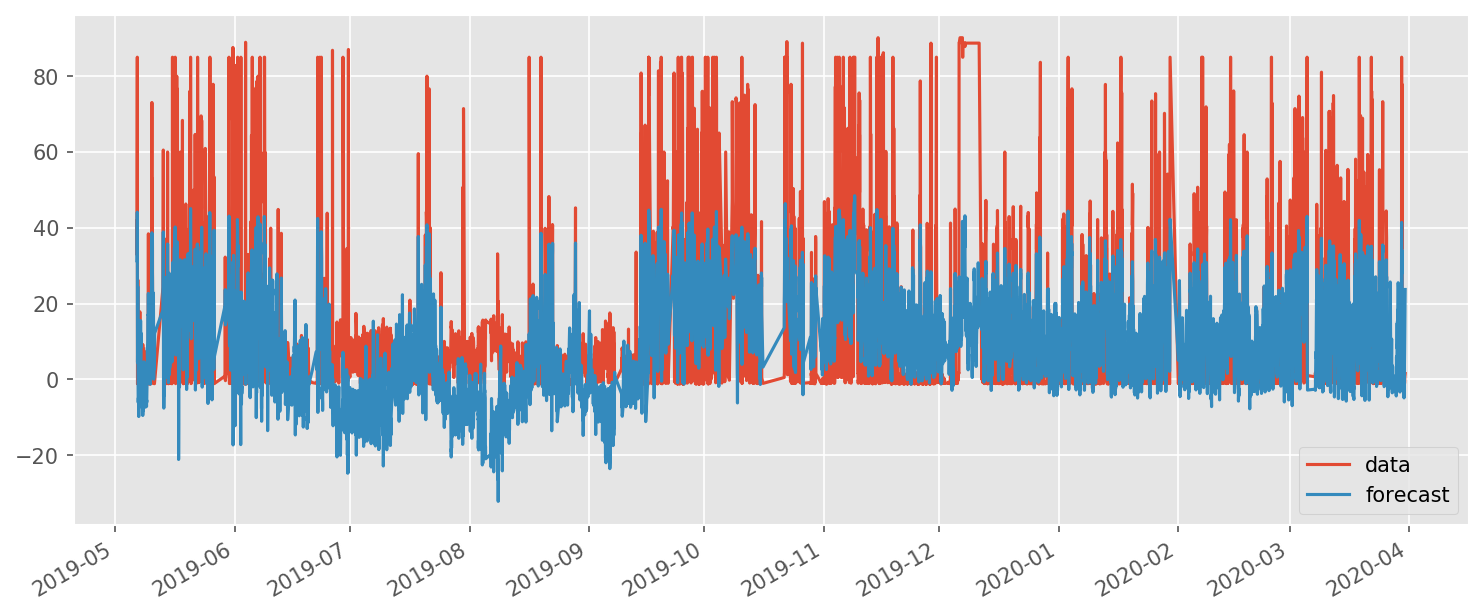

In [84]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
df1 = pd.DataFrame(Y_test.values,\
                           index=X_test.index, columns=['data'])
df1['forecast'] = blade_model.predict(X_test)
df1.plot(ax=ax)
plt.legend()
plt.show()

In [87]:
# names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed']
names_features = ['AmbientTemperatue', 'WindSpeed']
X = data1[names_features]
X = X.copy()
X['blades'] = blade_model.predict(X.iloc[:, 1:])
Y = data1.iloc[:, 0]

X.loc[:, ['AmbientTemperatue', 'WindSpeed']] = np.log(X.loc[:, ['AmbientTemperatue', 'WindSpeed']]+0.1)

validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

model = LinearRegression(normalize=False)
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(cv.mean())
model.fit(X_train, Y_train)
np.around(model.coef_)

-151.3356290097639


array([174., -31.,  -7.])

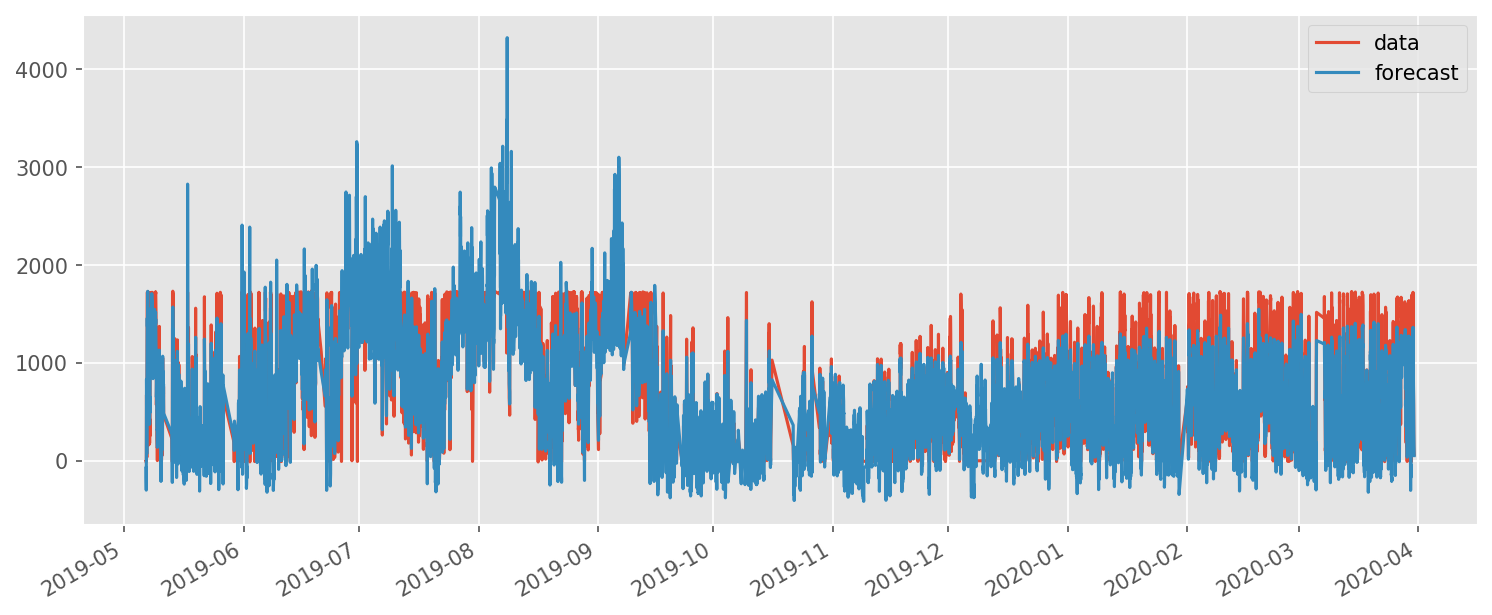

In [88]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

df1 = pd.DataFrame(Y_test.values, index=X_test.index, columns=['data'])
df1['forecast'] = model.predict(X_test)
df1.plot(ax=ax)

plt.show()

## Prediction

In [89]:
data3 = data.resample('D').last().dropna()

def features_forecast(name, period):
#     data_prophet = data1[[name]]
    
    data_prophet = data3[[name]]
    data_prophet = data_prophet.reset_index()
    data_prophet.columns = ['ds', 'y']
    
    model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
    model.fit(data_prophet)
    
    future = model.make_future_dataframe(periods=period, freq='D')
    forecast = model.predict(future)
    return forecast['yhat'].values[-period:]

In [90]:
forecast_values = []
# names_features = ['AmbientTemperatue', 'WindDirection', 'WindSpeed']
names_features = ['AmbientTemperatue', 'WindSpeed']
period = 7
for name in names_features:
    forecast_values.append(features_forecast(name, period))

In [91]:
X = data3[names_features]
X = X.copy()
X['blades'] = blade_model.predict(X.iloc[:, 1:])
Y = data3.iloc[:, 0]

X.loc[:, ['AmbientTemperatue', 'WindSpeed']] = np.log(X.loc[:, ['AmbientTemperatue', 'WindSpeed']]+1)

validation_size = 0.33
seed = 5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

model = LinearRegression(normalize=False)
scoring = 'neg_mean_absolute_error'
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
cv = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(cv.mean())
model.fit(X_train, Y_train)
np.around(model.coef_)

-97.65871951671892


array([  425., -1387.,   -14.])

In [92]:
x_blade_fc = blade_model.predict(np.array(forecast_values[1:]).T)
forecast_values.append(x_blade_fc.reshape(1, -1)[-1])

In [93]:
start = data3.index[-1] + pd.DateOffset(days=1)
end = start + pd.DateOffset(days=period-1)
forecast_df = pd.DataFrame(model.predict(np.array(forecast_values).T),\
                           index=pd.date_range(start, end), columns=['forecast'])

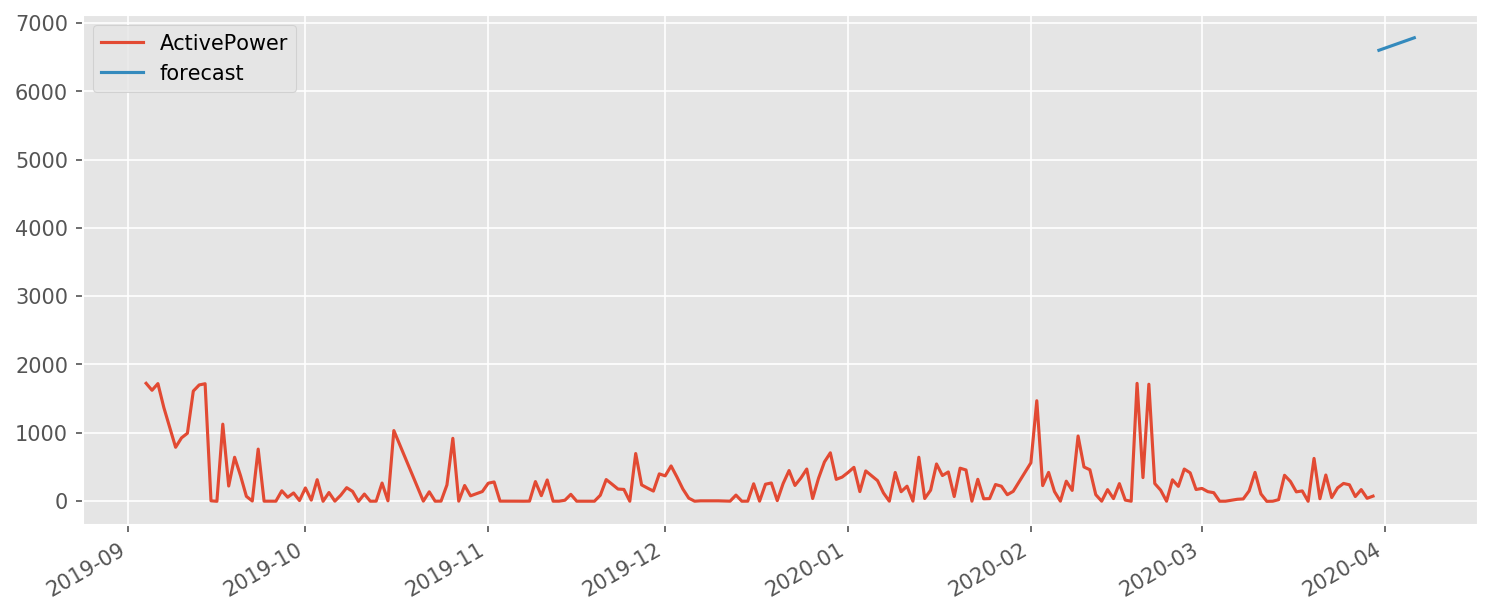

In [94]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

data3['ActivePower'].iloc[-200:].plot()
forecast_df.plot(ax=ax)
plt.legend()
plt.show()

In [95]:
forecast_values

[array([26.01676987, 26.06791484, 26.11905981, 26.17020478, 26.22134975,
        26.27249472, 26.32363969]),
 array([3.87073351, 3.86131456, 3.85189561, 3.84247666, 3.83305772,
        3.82363877, 3.81421982]),
 array([-54.6621584 , -54.35646699, -54.05077557, -53.74508415,
        -53.43939274, -53.13370132, -52.8280099 ])]